<img src='../img/LogoWekeo_Copernicus_RGB_0.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='10%'></img>

# Copernicus Sentinel-5 Precursor (Sentinel-5P) Level 2 Carbon Monoxide - Explore

This notebooks introduces you to the Sentinel-5P Level 2 Carbon Monoxide (CO) data product. Carbon Monoxide is a good trace gas in order to monitor and track fire occurences. The example in this notebook is based on the Siberian wildfires during summer 2021.

#### Module outline:
The notebook has the following outline:
* [1 - Unzip downloaded Sentinel-5P data](#unzip_s5p)
* [2 - Load and browse Sentinel-5P Level 2 Carbon Monoxide data](#load_s5p)
* [3 - Create a geographical subset](#geographical_subset)
* [4 - Visualize Sentinel-5P Level 2 Carbon Monoxide data](#plotting_s5p)

#### Load required libraries

In [7]:
import xarray as xr
import numpy as np
import zipfile

import matplotlib.pyplot as plt
from matplotlib.axes import Axes

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='unzip_s5p'></a> Unzip downloaded Sentinel-5P data

The Sentinel-5P data are disseminated as `NetCDF` files. However, WEkEO distributes the files as zip archives. Hence, the first step is to extract the data files from the zipped archive. You can use the Python package `zipfile` to do so. 

In [3]:
zip_ref = zipfile.ZipFile('../../data/S5P_OFFL_L2__CO_____20210812T034159_20210812T052329_19845_02_020200_20210813T173323.nc.zip') 
zip_ref.extractall('../../data/')
zip_ref.close()

## <a id="load_s5p"></a>Load and browse Sentinel-5P Level 2 Carbon Monoxide data

A Sentinel-5P file is organised in two groups: `PRODUCT` and `METADATA`. The `PRODUCT` group stores the main data fields of the product, including `latitude`, `longitude` and the variable itself. The `METADATA` group provides additional metadata items.

Sentinel-5P variables have the following dimensions:
* `scanline`: the number of measurements in the granule / along-track dimension index
* `ground_pixel`: the number of spectra in a measurement / across-track dimension index
* `time`: time reference for the data
* `corner`: pixel corner index
* `layer`: this dimension indicates the vertical grid of profile variables

Sentinel-5P data is disseminated in `NetCDF`. You can load multiple `NetCDF` files at once with the `open_mfdataset()` function of the xarray library. In order to load the variable as part of a Sentinel-5P data files, you have to specify the following keyword arguments: 
- `group='PRODUCT'`: to load the `PRODUCT` group
- `concat_dim='scanline'`: multiple files will be concatenated based on the scanline dimension
- `combine=nested`: combine n-dimensional grids into one along each dimension of the grid

Let us load a Sentinel-5P Level 2 Carbon Monoxide data file as `xarray.Dataset` and inspect the data structure:

In [8]:
s5p = xr.open_dataset('../../data/S5P_OFFL_L2__CO_____20210812T034159_20210812T052329_19845_02_020200_20210813T173323/S5P_OFFL_L2__CO_____20210812T034159_20210812T052329_19845_02_020200_20210813T173323.nc', group='PRODUCT')
s5p

<xarray.Dataset>
Dimensions:                                (scanline: 4172, ground_pixel: 215,
                                            time: 1, corner: 4, layer: 50)
Coordinates:
  * scanline                               (scanline) float64 0.0 ... 4.171e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 214.0
  * time                                   (time) datetime64[ns] 2021-08-12
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) float32 4.95e+04 ... 500.0
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                             (time, scanline) datetime64[ns] ...
    time_utc                               (time, scanline) object ...
    qa_value                               (time, scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column            (time, scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column_precision  (time, scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column_corrected  (time, scanline, ground_pixel) float32 ...

You see that a Sentinel-5P Level CO data product file contains of seven coordinate information and six data variables:
* **Coordinates**:
  * `scanline` 
  * `ground_pixel`
  * `time`
  * `corner`
  * `layer`
  * `latitude`
  * `longitude`

* **Data variables**:
  * `delta_time`: the offset of individual measurements within the granule, given in milliseconds
  * `time_utc`: valid time stamp of the data
  * `qa_value`: quality descriptor, varying between 0 (nodata) and 1 (full quality data)
  * `carbonmonoxide_total_column`: Vertically integrated total column Carbon Monoxide density
  * `carbonmonoxide_total_column_precision`: precision of the total column carbon monoxide
  * `carbonmonoxide_total_column_corrected`: Precision of the tropospheric vertical column of NO2 when the averaging kernel is applied

  

You can select on data variable of interest and get more detailed information about the variable. E.g. `carbonmonoxide_total_column` is the atmosphere mole content of carbon monoxide, has the unit `mol per m-2`, and has three dimensions, `time`, `scanline` and `ground_pixel` respectively.

By specifying one specific data variable, you load extract a `xarray.DataArray`.

In [9]:
s5p_co = s5p['carbonmonoxide_total_column']
s5p_co

<xarray.DataArray 'carbonmonoxide_total_column' (time: 1, scanline: 4172,
                                                 ground_pixel: 215)>
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * time          (time) datetime64[ns] 2021-08-12
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

You can repeat the same operation for the other available variables, but also for the dimensions latitude and longitude, to get a better overview of the geographic dimension.

In [10]:
print('Latitude')
print(s5p_co.latitude)

print('Longitude')
print(s5p_co.longitude)

Latitude
<xarray.DataArray 'latitude' (time: 1, scanline: 4172, ground_pixel: 215)>
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * time          (time) datetime64[ns] 2021-08-12
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    long_name:      pixel center latitude
    units:          degrees_north
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      90.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/latitude_bounds
Longitude
<xarray.DataArray 'longitude' (time: 1, scanline: 4172, ground_pixel: 215)>
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
  * time          (t

<br>

In a next step, let us simplify the loaded `xarray.DataArray` and directly select the single time step. One single time step can be selected by specifying one value of the time dimension, e.g. `[0,:,:]`. The result is the array with two remaining dimensions: scanline and ground_pixel.

In [11]:
s5p_co_1208 = s5p_co[0,:,:]
s5p_co_1208

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 4172,
                                                 ground_pixel: 215)>
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2021-08-12
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

The attributes of the data array hold the entry `multiplication_factor_to_convert_to_molecules_percm2`, which is a conversion factor that has to be applied to convert the data from mol / m<sup>2</sup> to molecules / cm<sup>2</sup>.

Let us store the multiplication factor as variable with the name `conversion_factor`.


In [12]:
conversion_factor = s5p_co_1208.multiplication_factor_to_convert_to_molecules_percm2
conversion_factor

6.022141e+19

Additionally, you can save the attribute `longname`, which you be handy for data visualisation in a later step.

In [13]:
longname = s5p_co_1208.long_name
longname

'Vertically integrated CO column'

## <a id='geographical_subset'></a>Create  a geographical subset

You can zoom into a specific region by specifying a `bounding box` of interest. Let us set the extent to central Siberia with the following bounding box information:

In [14]:
latmax=75
latmin=31
lonmax=150
lonmin=100

You can use the function [generate_geographical_subset()](../functions.ipynb#generate_geographical_subset) to subset a `xarray.DataArray` based on a given bounding box.

In [15]:
s5p_co_subset = generate_geographical_subset(s5p_co_1208, latmin, latmax, lonmin, lonmax)
s5p_co_subset

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 936,
                                                 ground_pixel: 215)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 2.322e+03 2.323e+03 ... 3.256e+03 3.257e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2021-08-12
    latitude      (scanline, ground_pixel) float32 25.37 25.53 ... 75.81 75.7
    longitude     (scanline, ground_pixel) float32 115.7 116.1 ... 143.0 144.2
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

<br>

## <a id="plotting_s5p"></a>Visualise Sentinel-5P Level 2 Carbon Monoxide data

You can plot data arrays of type `numpy` with matplotlib's `pcolormesh` function. In combination with the library [Cartopy](https://scitools.org.uk/cartopy/docs/latest/), you can produce high-quality maps. 

In order to make it easier to visualize the Carbon Monoxide values, we apply the conversion factor to the data array. This converts the Carbon Monoxide values from mol per m<sup>2</sup> to molecules per cm<sup>2</sup>.

In [16]:
s5p_co_converted = s5p_co_subset*conversion_factor
s5p_co_converted

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 936,
                                                 ground_pixel: 215)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 2.322e+03 2.323e+03 ... 3.256e+03 3.257e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2021-08-12
    latitude      (scanline, ground_pixel) float32 25.37 25.53 ... 75.81 75.7
    longitude     (scanline, ground_pixel) float32 115.7 116.1 ... 143.0 144.2

For visualization, you can use the function [visualize_pcolormesh](../functions#visualize_pcolormesh) to visualize the data. The following kwargs have to be defined:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color_scale`
* `unit`
* `long_name`
* `vmin`, `vmax`
* `extent (lonmin, lonmax, latmin, latmax)`
* `set_global`

Now, let us apply the [visualize_pcolormesh](../functions#visualize_pcolormesh) function and visualize the vertically integrated Carbon Monoxide column sensored from the Sentinel-5P satellite over central Siberia on 12 August 2021.

*Note: Multiplying the data array values with 1e<sup>-18</sup> improves the readibility of the map legend.*

(<Figure size 2000x1000 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Vertically integrated CO column - 12 August 2021'}>)

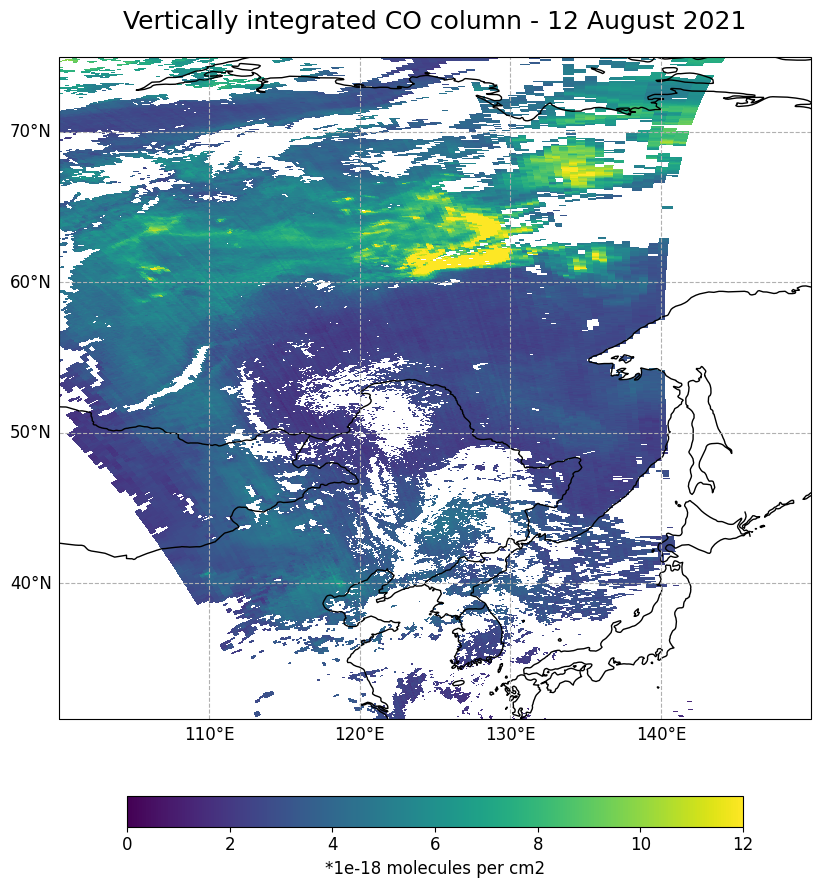

In [17]:
visualize_pcolormesh(data_array=s5p_co_converted*1e-18, 
                     longitude=s5p_co_converted.longitude, 
                     latitude=s5p_co_converted.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='viridis', 
                     unit='*1e-18 molecules per cm2', 
                     long_name=longname + " - 12 August 2021" , 
                     vmin=0, 
                     vmax=12, 
                     lonmin=lonmin, 
                     lonmax=lonmax, 
                     latmin=latmin, 
                     latmax=latmax, 
                     set_global=False)


<br>

<hr>